# Telecom Churn Case Study - Kaggle

`References`


- https://medium.com/analytics-vidhya/telecom-churn-prediction-9ce72c24e961
- https://github.com/akashkriplani/telecom-churn-case-study/tree/main


# Problem Statement

This is a student exercise using telecom churn data. The goal is to build a model to predict customer churn probability. The data is provided in two parts: one dataset with known churn outcomes (`train.csv`) and another without churn outcomes (`test.csv`).

### Exercise Overview:

1. **80% weightage:** Focus on building the best model for the business case—predicting churn probability based on multiple KPIs.
2. **20% weightage:** A submission to a Kaggle competition, where the model is evaluated on unseen data (`test.csv`).

The data contains KPIs measured across months, and our EDA will explore how these KPIs evolve over time. We will also test different models to compare their performance and choose the best one for Kaggle submission.

The model with the highest accuracy will be selected for the Kaggle submission, even if it is not the best across all evaluation metrics.


# Module imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

import re
import numpy as np
import pandas as pd ; pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

# Utility functions

In [3]:
from typing import Tuple, Any
from sklearn.experimental import enable_iterative_imputer  # Required to use IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer, KNNImputer

def detailed_summary(data: pd.DataFrame, display_top_n=3) -> pd.DataFrame:
    """
    Provides detailed summary for both categorical and numerical variables.

    Data    : Pandas dataframe
    display_top_n : Number of top frequent values to display for categorical variables.
    
    Returns :
        Pandas dataframe with descriptive summary for both categorical and numerical columns.
    """
    # Separate numerical and categorical columns
    categorical_columns = data.select_dtypes(exclude=['int64', 'float64']).columns
    numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
    
    numerical_summary = pd.DataFrame()
    categorical_summary = pd.DataFrame()

    if len(numerical_columns) > 0:
        # Summary for numerical columns
        numerical_summary = data[numerical_columns].describe().T
        numerical_summary['count'] = data[numerical_columns].count()
        numerical_summary['dtype'] = data[numerical_columns].dtypes
        numerical_summary['missing_values %'] = round(data[numerical_columns].isna().sum() / len(data) * 100, 2)
        # numerical_summary['skew'] = data[numerical_columns].skew()
        # numerical_summary['kurtosis'] = data[numerical_columns].kurtosis()
        numerical_summary['unique_values'] = data[numerical_columns].nunique(dropna=True)
        numerical_summary['single_unique_value'] = data[numerical_columns].apply(lambda x: 'Yes' if x.nunique(dropna=True) == 1 else 'No')

    if len(categorical_columns) > 0:
        # Summary for categorical columns
        categorical_summary = pd.DataFrame(index=categorical_columns)
        categorical_summary['count'] = data[categorical_columns].count()
        categorical_summary['dtype'] = data[categorical_columns].dtypes
        categorical_summary['missing_values %'] = round(data[categorical_columns].isna().sum() / len(data) * 100, 2)
        categorical_summary['unique_values'] = data[categorical_columns].nunique()
        categorical_summary['most_frequent'] = data[categorical_columns].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
        categorical_summary['frequency'] = data[categorical_columns].apply(lambda x: x.value_counts().iloc[0] if not x.value_counts().empty else None)
        # categorical_summary['top_n_frequent'] = data[categorical_columns].apply(lambda x: dict(x.value_counts().head(display_top_n)))
        # categorical_summary['single_unique_value'] = data[categorical_columns].apply(lambda x: 'Yes' if x.nunique() == 1 else 'No')

    # Combine both summaries
    return pd.concat([numerical_summary, categorical_summary], axis=0)

def find_columns_by_string(data : pd.DataFrame, search_string : str):
    """
    find columns which has given search string
    """
    return [col for col in data.columns if search_string.lower() in col.lower()]

def find_columns_by_regex(data, regex_pattern):
    """
    find columns which has search string matching regex pattern
    """
    return [col for col in data.columns if re.search(regex_pattern, col, re.IGNORECASE)]

def handle_missing_values(data: pd.DataFrame, strategy="mean", impute_categorical=False, knn_neighbors=5) -> Tuple[Any, pd.DataFrame]:
    """
    TODO: Function need work. handling of mix dtypes is not done correctly.

    Handles missing values in the dataframe based on the provided strategy.
    
    strategy : str, default "mean"
        Imputation strategy for numerical columns:
        - "mean": replaces missing values with mean
        - "median": replaces missing values with median
        - "most_frequent": replaces missing values with the most frequent value
        - "knn": uses KNN imputer
        - "iterative": uses Iterative imputer (more advanced)
    
    impute_categorical : bool, default True
        Whether to impute categorical variables with the most frequent value.
    
    knn_neighbors : int, default 5
        Number of neighbors to use for KNN imputation.
    
    Returns:
        imputer --> useful for imputing test sets or review model parameters.
        DataFrame with missing values handled.
    """
    
    data_cleaned = data.copy()
    
    # Separate numerical and categorical columns
    numerical_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = data_cleaned.select_dtypes(exclude=['float64', 'int64']).columns
    
    if len(numerical_cols) > 0:
        # Handle missing values for numerical columns
        if strategy in ["mean", "median", "most_frequent"]:
            imputer = SimpleImputer(strategy=strategy)
            data_cleaned[numerical_cols] = imputer.fit_transform(data_cleaned[numerical_cols])
        
        elif strategy == "knn":
            imputer = KNNImputer(n_neighbors=knn_neighbors)
            data_cleaned[numerical_cols] = imputer.fit_transform(data_cleaned[numerical_cols])
        
        elif strategy == "iterative":
            imputer = IterativeImputer()
            data_cleaned[numerical_cols] = imputer.fit_transform(data_cleaned[numerical_cols])
    
    # Handle missing values for categorical columns (if applicable)
    if len(categorical_cols) > 0 and impute_categorical:
        imputer = SimpleImputer(strategy="most_frequent")
        data_cleaned[categorical_cols] = imputer.fit_transform(data_cleaned[categorical_cols])
    
    return imputer, data_cleaned

# Load data

### Links to data on google drive 

- https://drive.google.com/uc?id=1BTXvDT0JQK_bNXEMBJCSl4AWgDlBHMVv - train.csv
- https://drive.google.com/uc?id=1NeIn5Y199H1WNYxZbryUwrKdxHw3tjHz - test.csv
- https://drive.google.com/uc?id=1cN3iMwxib1a_8POB3DZDf9g9_kQJ-onV - sample.csv
- https://drive.google.com/uc?id=11YclgZdYOuJYptrNutqCOoLgf4bz9xL8 - dictionary.csv

In [4]:
# data = pd.read_csv("data/train.csv")
# unseen = pd.read_csv("data/test.csv")
# kaggle_submisson_sample = pd.read_csv("data/sample.csv")
# data_dictionary = pd.read_csv("data/data_dictionary.csv")

# Load data from google drive.
data = pd.read_csv("https://drive.google.com/uc?id=1BTXvDT0JQK_bNXEMBJCSl4AWgDlBHMVv")
unseen = pd.read_csv("https://drive.google.com/uc?id=1NeIn5Y199H1WNYxZbryUwrKdxHw3tjHz")
kaggle_submisson_sample = pd.read_csv("https://drive.google.com/uc?id=1cN3iMwxib1a_8POB3DZDf9g9_kQJ-onV")
data_dictionary = pd.read_csv("https://drive.google.com/uc?id=11YclgZdYOuJYptrNutqCOoLgf4bz9xL8")

In [ ]:
print("train.csv", data.shape)
print("test.csv", unseen.shape)
print("sample.csv", kaggle_submisson_sample.shape)

`data_dictionary.csv`

|Acronyms|Description|
|---|---|
|CIRCLE_ID|Telecom circle area to which the customer belongs to|
|LOC|Local calls  within same telecom circle|
|STD|STD calls  outside the calling circle|
|IC|Incoming calls|
|OG|Outgoing calls|
|T2T|Operator T to T ie within same operator mobile to mobile|
|T2M    |Operator T to other operator mobile|
|T2O    |Operator T to other operator fixed line|
|T2F    |Operator T to fixed lines of T|
|T2C    |Operator T to its own call center|
|ARPU    |Average revenue per user|
|MOU    |Minutes of usage  voice calls|
|AON    |Age on network  number of days the customer is using the operator T network|
|ONNET   |All kind of calls within the same operator network|
|OFFNET    |All kind of calls outside the operator T network|
|ROAM|Indicates that customer is in roaming zone during the call|
|SPL   |Special calls|
|ISD    |ISD calls|
|RECH    |Recharge|
|NUM    |Number|
|AMT    |Amount in local currency|
|MAX    |Maximum|
|DATA    |Mobile internet|
|3G    |G network|
|AV    |Average|
|VOL    |Mobile internet usage volume in MB|
|2G    |G network|
|PCK    |Prepaid service schemes called  PACKS|
|NIGHT    |Scheme to use during specific night hours only|
|MONTHLY    |Service schemes with validity equivalent to a month|
|SACHET   |Service schemes with validity smaller than a month|
|*.6    |KPI for the month of June|
|*.7    |KPI for the month of July|
|*.8    |KPI for the month of August|
|FB_USER|Service scheme to avail services of Facebook and similar social networking sites|
|VBC    |Volume based cost  when no specific scheme is not purchased and paid as per usage|

In [6]:
# data_dictionary

In [ ]:
detailed_summary(data).sort_values(by=['unique_values'])

## Initial review of data summary
1. Column `circle_id` can go as it only has one unique value across all users.
2. We have also have columns last_date_of_month_6,  last_date_of_month_7 and last_date_of_month_8 which can go as well as these are just date for end of the month.
3. We have columns fb_user_* with binary value and most likley defining user or non user of fb pack. These columns have high missig value of ~74%. Same with columns night_pck_user_*
4. Columns 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7' and 'std_ic_t2o_mou_8' have all zeros and few missing.
5. Columns 'loc_og_t2o_mou', 'std_og_t2o_mou' and 'loc_ic_t2o_mou' have same story of all zeroes but no missing.  
6. Columns 'std_og_t2c_mou_6', 'std_og_t2c_mou_7' and 'std_og_t2c_mou_8' have all zeros and few missing


# Task at hand

`Task at hand is to build model to predict churn for high value customers.` We will split data by high value customer. This should help lightern the load as we deal with less records in further steps.

# Data Cleaning

## Dropping columns based on initial review


In [8]:

columns_to_drop_initial_review = ['circle_id', 
                                  'loc_og_t2o_mou', 
                                  'std_og_t2o_mou', 
                                  'loc_ic_t2o_mou', 
                                  'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8',
                                  'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
                                  'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8'
] 

data = data.drop(columns=columns_to_drop_initial_review)
unseen = unseen.drop(columns=columns_to_drop_initial_review)

We have removed all columns with unique values

## Fix data type for categorical variables

In [ ]:
pd.DataFrame(data.nunique()).sort_values(by=[0]).head(n=10) # Checking if we have columns with unique values

Let's put fb_user_* and night_pck_user_* into a bucket as these are categorical columns with True and False values


In [ ]:
binary_categorical = find_columns_by_regex(data=data, regex_pattern=r'.*fb_user.*|.*night_pck_user.*')
binary_categorical

In [11]:
data[binary_categorical] = data[binary_categorical].astype('category')
unseen[binary_categorical] = unseen[binary_categorical].astype('category')
data[['churn_probability']] = data[['churn_probability']].astype('category') # Reminding ourselves churn_probability is not included in the unseen data


## Date columns

In [ ]:
date_columns = [v for v in data.columns if v.startswith('date_')]
date_columns

We have determined that the dates provided represent the last recharge within each month. However, we do not know whether the absence of a recharge in a given month indicates that the customer did not recharge at all or had opted for a longer validity in the previous month.

Due to the lack of additional information, we will drop these columns as they cannot be reliably used in our analysis.


In [13]:
data = data.drop(columns=date_columns)
unseen = unseen.drop(columns=date_columns)

## Get columns with high missing values

In [ ]:
columns_with_70perct_missing = list(data.columns[data.isnull().mean() > 0.50])
columns_with_70perct_missing

We have determined that these columns do not actually have missing data; instead, the absence of data carries meaning. We will handle each set of columns accordingly based on their specific context.

- Variables like `total_rech_num_6` can be filled with `0` to indicate zero recharges.
- Columns such as `night_pck_user_*` and `fb_user_*` are categorical, and missing data indicates the absence of a subscription to the service. We will mark these missing values as `-1`.

In [ ]:
columns_to_zero_fill = find_columns_by_regex(data=data,
                                             regex_pattern=r'_rech_|arpu_3g|arpu_2g')
columns_to_zero_fill


## Columns with high missing values to fill with zero

```python 
[
    'total_rech_num_6',
    'total_rech_num_7',
    'total_rech_num_8',
    'total_rech_amt_6',
    'total_rech_amt_7',
    'total_rech_amt_8',
    'max_rech_amt_6',
    'max_rech_amt_7',
    'max_rech_amt_8',
    'total_rech_data_6',
    'total_rech_data_7',
    'total_rech_data_8',
    'max_rech_data_6',
    'max_rech_data_7',
    'max_rech_data_8',
    'count_rech_2g_6',
    'count_rech_2g_7',
    'count_rech_2g_8',
    'count_rech_3g_6',
    'count_rech_3g_7',
    'count_rech_3g_8',
    'av_rech_amt_data_6',
    'av_rech_amt_data_7',
    'av_rech_amt_data_8',
    'arpu_3g_6',
    'arpu_3g_7',
    'arpu_3g_8',
    'arpu_2g_6',
    'arpu_2g_7',
    'arpu_2g_8'
]


In [16]:
columns_to_zero_fill = [
    'total_rech_num_6',
    'total_rech_num_7',
    'total_rech_num_8',
    'total_rech_amt_6',
    'total_rech_amt_7',
    'total_rech_amt_8',
    'max_rech_amt_6',
    'max_rech_amt_7',
    'max_rech_amt_8',
    'total_rech_data_6',
    'total_rech_data_7',
    'total_rech_data_8',
    'max_rech_data_6',
    'max_rech_data_7',
    'max_rech_data_8',
    'count_rech_2g_6',
    'count_rech_2g_7',
    'count_rech_2g_8',
    'count_rech_3g_6',
    'count_rech_3g_7',
    'count_rech_3g_8',
    'av_rech_amt_data_6',
    'av_rech_amt_data_7',
    'av_rech_amt_data_8',
    'arpu_3g_6',
    'arpu_3g_7',
    'arpu_3g_8',
    'arpu_2g_6',
    'arpu_2g_7',
    'arpu_2g_8'
]

In [17]:
data[columns_to_zero_fill] = data[columns_to_zero_fill].fillna(0)
unseen[columns_to_zero_fill] = unseen[columns_to_zero_fill].fillna(0)

## Categorical variables to fill with -1 to peserve meaning of the existing data

In [18]:
# Add -1 as a new category to the categorical columns
data[binary_categorical] = data[binary_categorical].apply(lambda col: col.cat.add_categories([-1]))
unseen[binary_categorical] = unseen[binary_categorical].apply(lambda col: col.cat.add_categories([-1]))

# Now, fill missing values with -1
data[binary_categorical] = data[binary_categorical].fillna(-1)
unseen[binary_categorical] = unseen[binary_categorical].fillna(-1)

## Impute missing data

In [ ]:
columns_with_few_missing = list(data.columns[(data.isnull().mean() < 0.50) & (data.isnull().mean() > 0)])
len(columns_with_few_missing)

In [ ]:
data[columns_with_few_missing].head(n=5).T

In [21]:
# simple_imputer, imputed_data = handle_missing_values(
#     data=data[columns_with_few_missing],
#     strategy='knn',
#     impute_categorical=False
#     )

In [ ]:
%%time
KNNImputer, imputed_data = handle_missing_values(
    data=data[columns_with_few_missing],
    strategy='knn',
    impute_categorical=True
    )

In [ ]:
detailed_summary(data[columns_with_few_missing]).head(5)

In [ ]:
detailed_summary(imputed_data).head(5)

In [25]:
data[columns_with_few_missing] = imputed_data                                               # Train data updated with imputed data

In [26]:
unseen[columns_with_few_missing] = KNNImputer.transform(unseen[columns_with_few_missing] )  # Unseen data transformed with imputer model

In [27]:
assert ([] == list(data.columns[(data.isnull().mean() > 0)]))       # this list should be empty indicating there are no columns with missing values at this stage.
assert ([] == list(unseen.columns[(unseen.isnull().mean() > 0)]))   # this list should be empty indicating there are no columns with missing values at this stage.

# High Value customers

### High-Value Customer Definition

`Definition borrowed from : https://github.com/akashkriplani/telecom-churn-case-study/tree/main`

To identify high-value customers, we look at their total recharge behavior, focusing on both regular and data recharges over two months (months 6 and 7):

- **Recharge Calculation**: We consider both the number of data recharges (`total_rech_data_6`, `total_rech_data_7`) and the average recharge amounts for these recharges (`av_rech_amt_data_6`, `av_rech_amt_data_7`). These are combined with regular recharge amounts (`total_rech_amt_6`, `total_rech_amt_7`) to get the total recharge value for each month.

- **Average Recharge Amount**: The average of the total recharge amounts from months 6 and 7 is then calculated for each customer, giving an indicator of their overall recharge behavior.

- **High-Value Customer Flag**: A cutoff is set at the 70th percentile of these average recharge values. Customers exceeding this threshold are flagged as high-value, indicating they are among the top spenders in terms of recharges.

This approach ensures that high-value customers are identified based on their significant recharge activity across both months, excluding churn month of August.

In [28]:
cutoff = 0.7

# Calculate total recharge amounts for months 6 and 7 (data + regular recharges)
data['rech_data_amt_6'] = data['total_rech_data_6'] * data['av_rech_amt_data_6']
data['rech_data_amt_7'] = data['total_rech_data_7'] * data['av_rech_amt_data_7']

data['total_amt_6'] = data['total_rech_amt_6'] + data['rech_data_amt_6']
data['total_amt_7'] = data['total_rech_amt_7'] + data['rech_data_amt_7']

# Compute the average total amount for months 6 and 7
data['avg_rech_amt_6_7'] = data[['total_amt_6', 'total_amt_7']].mean(axis=1)

# Define the cutoff for high-value customers
high_value_cutoff = data['avg_rech_amt_6_7'].quantile(cutoff)

# Create a flag for high-value customers
high_value_customer_train = data['avg_rech_amt_6_7'] > high_value_cutoff

In [ ]:
pd.DataFrame(high_value_customer_train).value_counts()

In [30]:
# Calculate total recharge amounts for months 6 and 7 (unseen + regular recharges)
unseen['rech_data_amt_6'] = unseen['total_rech_data_6'] * unseen['av_rech_amt_data_6']
unseen['rech_data_amt_7'] = unseen['total_rech_data_7'] * unseen['av_rech_amt_data_7']

unseen['total_amt_6'] = unseen['total_rech_amt_6'] + unseen['rech_data_amt_6']
unseen['total_amt_7'] = unseen['total_rech_amt_7'] + unseen['rech_data_amt_7']

# Compute the average total amount for months 6 and 7
unseen['avg_rech_amt_6_7'] = unseen[['total_amt_6', 'total_amt_7']].mean(axis=1)

# Define the cutoff for high-value customers
# Using cut off as per train data

# Create a flag for high-value customers
high_value_customer_unseen = unseen['avg_rech_amt_6_7'] > high_value_cutoff

In [ ]:
pd.DataFrame(high_value_customer_train).value_counts()

In [32]:
data_copy = data.copy(deep=True)
data = data[high_value_customer_train]

In [ ]:
assert(data.shape[1] == unseen.shape[1]+1) # Unseen has one less column
data.shape, unseen.shape

# EDA

## Correlations

In [ ]:
# We are not only exporting correlation scores to CSV but also ensuring each pair only appears once, reducing overload of information. 

# Create a temporary copy of the data without the 'id' column
data_temp = data.drop(columns=['id'])

# Divide the data by churn probability
data_churn_0 = data_temp[data_temp['churn_probability'] == 0]
data_churn_1 = data_temp[data_temp['churn_probability'] == 1]

# Calculate the correlation matrix for each group and the overall correlation matrix
correlation_matrix_total = data_temp.corr().round(4)
correlation_matrix_0 = data_churn_0.corr().round(4)
correlation_matrix_1 = data_churn_1.corr().round(4)

# Get the upper triangle of the correlation matrix for each group and the total
upper_triangle_total = correlation_matrix_total.where(
    np.triu(np.ones(correlation_matrix_total.shape), k=1).astype(bool)
)
upper_triangle_0 = correlation_matrix_0.where(
    np.triu(np.ones(correlation_matrix_0.shape), k=1).astype(bool)
)
upper_triangle_1 = correlation_matrix_1.where(
    np.triu(np.ones(correlation_matrix_1.shape), k=1).astype(bool)
)

# Unstack the matrices and drop NaN values
correlation_pairs_total = upper_triangle_total.unstack().dropna()
correlation_pairs_0 = upper_triangle_0.unstack().dropna()
correlation_pairs_1 = upper_triangle_1.unstack().dropna()

# Convert the correlation pairs to dataframes
correlation_pairs_df_total = correlation_pairs_total.reset_index()
correlation_pairs_df_total.columns = ['Variable 1', 'Variable 2', 'Correlation (Total)']

correlation_pairs_df_0 = correlation_pairs_0.reset_index()
correlation_pairs_df_0.columns = ['Variable 1', 'Variable 2', 'Correlation (Churn=0)']

correlation_pairs_df_1 = correlation_pairs_1.reset_index()
correlation_pairs_df_1.columns = ['Variable 1', 'Variable 2', 'Correlation (Churn=1)']

# Merge the correlation dataframes
correlation_pairs_df = correlation_pairs_df_total.merge(correlation_pairs_df_0, on=['Variable 1', 'Variable 2'], how='left')
correlation_pairs_df = correlation_pairs_df.merge(correlation_pairs_df_1, on=['Variable 1', 'Variable 2'], how='left')
correlation_pairs_df['Correlation (Total) (ABS)'] = correlation_pairs_df['Correlation (Total)'].abs()
correlation_pairs_df['Correlation (Churn=0) (ABS)'] = correlation_pairs_df['Correlation (Churn=0)'].abs()
correlation_pairs_df['Correlation (Churn=1) (ABS)'] = correlation_pairs_df['Correlation (Churn=1)'].abs()

# Save the merged correlation pairs to a CSV file
correlation_pairs_df.to_csv('correlation_pairs_combined.csv', index=False)

print("Combined correlation pairs saved to 'correlation_pairs_combined.csv'")

1. Revenue v/s recharge
- Correlation of revenue with respective month indicate recharge for the month is directly reflected towards revenue for the month
- Low correlation between revenue and recharge amounged churned users may also indicate users tend to spend less as they churn
- Number of recharge follow similat trend

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| total_rech_amt_6 | arpu_6 | 0.9528 | 0.9536 | 0.9477 |
| total_rech_amt_6 | arpu_7 | 0.7511 | 0.7880 | 0.4823 |
| total_rech_amt_6 | arpu_8 | 0.6390 | 0.6936 | 0.2420 |
| total_rech_amt_7 | arpu_6 | 0.7260 | 0.7705 | 0.4173 |
| total_rech_amt_7 | arpu_7 | 0.9553 | 0.9560 | 0.9461 |
| total_rech_amt_7 | arpu_8 | 0.7788 | 0.8003 | 0.5374 |
| total_rech_amt_8 | arpu_6 | 0.6268 | 0.6871 | 0.1989 |
| total_rech_amt_8 | arpu_7 | 0.7672 | 0.7913 | 0.4927 |
| total_rech_amt_8 | arpu_8 | 0.9583 | 0.9582 | 0.9405 |

<br />

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| total_rech_num_7 | total_rech_num_6 | 0.6703 | 0.7002 | 0.4854 |
| total_rech_num_8 | total_rech_num_6 | 0.5167 | 0.5649 | 0.2084 |
| total_rech_num_8 | total_rech_num_7 | 0.7239 | 0.7418 | 0.5518 |



2. Outgoin ISD calls

- Users likey start making less call as the are about to churn as shown in reduced correlation in churn v/s previous month 
- User which do not churn continue to likely make similar amount of calls

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| total_og_mou_8 | total_og_mou_7 | 0.7693 | 0.7928 | 0.5873 |
| total_og_mou_7 | total_og_mou_6 | 0.7245 | 0.7464 | 0.6102 |
| total_og_mou_8 | total_og_mou_6 | 0.5659 | 0.6157 | 0.2840 |

<br />

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| isd_og_mou_8 | isd_og_mou_7 | 0.9470 | 0.9582 | 0.5492 |
| isd_og_mou_7 | isd_og_mou_6 | 0.9340 | 0.9588 | 0.4444 |
| isd_og_mou_8 | isd_og_mou_6 | 0.9241 | 0.9526 | 0.2640 |

3. Churn v/s age of network
- Very low negative correlation indicating as age increases churn probability reduces but is not guaranteed
- This correlation is likely affected by class imbalance as well and I would other expect bit higher negative correlation

| Variable 1 | Variable 2 | Correlation (Total) |
| --- | --- | --- |
| churn_probability | aon | -0.1352 |


4. Within operator network and outside operator network
- Similar trend of low correlation between months which are further apart, indicating call volume goes down as people churn.

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| onnet_mou_8 | onnet_mou_7 | 0.7875 | 0.8081 | 0.6340 |
| onnet_mou_7 | onnet_mou_6 | 0.7339 | 0.7510 | 0.6528 |
| onnet_mou_8 | onnet_mou_6 | 0.5978 | 0.6421 | 0.3567 |

<br />

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| offnet_mou_8 | offnet_mou_7 | 0.7557 | 0.7796 | 0.5331 |
| offnet_mou_7 | offnet_mou_6 | 0.7405 | 0.7597 | 0.6321 |
| offnet_mou_8 | offnet_mou_6 | 0.5734 | 0.6178 | 0.2713 |



## Change in monthly KPI churn vs non-churn
Let's explore these monthly KPI relationship little bit more.

In [35]:
def get_monthly_column_groups(data: pd.DataFrame) -> list[tuple[str, str, str]]:
    """
    Find columns with names ending in _6, _7, and _8 and return them as a list of tuples.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the column names.

    Returns:
    list[tuple[str, str, str]]: A list of tuples, where each tuple contains the column names for June (_6), July (_7), and August (_8).
    """
    columns_6 = [col for col in data.columns if col.endswith('_6')]
    columns_7 = [col for col in data.columns if col.endswith('_7')]
    columns_8 = [col for col in data.columns if col.endswith('_8')]

    monthly_columns = []
    for col_6 in columns_6:
        base_name = col_6[:-2]
        col_7 = f'{base_name}_7'
        col_8 = f'{base_name}_8'
        if col_7 in columns_7 and col_8 in columns_8:
            monthly_columns.append((col_6, col_7, col_8))

    return monthly_columns

def plot_usage_volume(data: pd.DataFrame, col_june: str, col_july: str, col_aug: str) -> None:
    """
    Plot line graphs showing average June, July, and August volume, split by churn and non-churn.

    Parameters:
    data (pd.DataFrame): The DataFrame containing user data, including a unique identifier for each respondent and a churn indicator.
    col_june (str): The column name for June data.
    col_july (str): The column name for July data.
    col_aug (str): The column name for August data.
    """
    # Split data into churned and non-churned users
    churned = data[data['churn_probability'] == 1]
    non_churned = data[data['churn_probability'] == 0]

    # Calculate mean volumes for June, July, and August for churned and non-churned users
    june_churned_mean = churned[col_june].mean()
    july_churned_mean = churned[col_july].mean()
    aug_churned_mean = churned[col_aug].mean()

    june_non_churned_mean = non_churned[col_june].mean()
    july_non_churned_mean = non_churned[col_july].mean()
    aug_non_churned_mean = non_churned[col_aug].mean()

    # Prepare data for plotting
    categories = ['June', 'July', 'August']
    churned_values = [june_churned_mean, july_churned_mean, aug_churned_mean]
    non_churned_values = [june_non_churned_mean, july_non_churned_mean, aug_non_churned_mean]

    base_name = col_june[:-2]

    # Plotting
    plt.figure(figsize=(6, 4))
    plt.plot(categories, churned_values, label='Churned', marker='o', color='red')
    plt.plot(categories, non_churned_values, label='Non-Churned', marker='o', color='green')

    plt.xlabel('Month')
    plt.ylabel('Average Usage Volume')
    plt.title(f'{base_name}\nAverage Usage Volume Comparison: Churned vs Non-Churned Users')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
numeric_columns = data.select_dtypes(include=['number']).columns       # We are only interested in volume baed data for the next plots. 
column_groups = get_monthly_column_groups (data=data[numeric_columns])  # Get monthly KPI as tuples of June, July and August in that order.
print (f'Plotting {len(column_groups)} KPI of pairs')

In [ ]:
for c in column_groups:
    #---------------------------------------------
    # Plotting
    #--------------- ------------------------------
    print (f'{c[0][:-2]}')
    plot_usage_volume(
        data=data,
        col_june=c[0],
        col_july=c[1],
        col_aug=c[2]
    )

## Outliers

In [38]:
def outlier_handling(dataframe, method='log', cap_value=None):
    """
    Applies outlier handling transformations to the values in the given DataFrame.
    
    Parameters:
    - dataframe (DataFrame or Series): The DataFrame or Series containing the values to be transformed.
    - method (str): The method to handle outliers. Can be 'log', 'clip', or 'none'.
                    - 'log' applies log(1 + x) for positive values.
                    - 'clip' clips the values to a specified upper limit (cap_value).
                    - 'none' leaves the values unchanged (except for handling negative or zero values).
    - cap_value (float, optional): The upper limit for clipping. Only used if method='clip'.
    
    Returns:
    - transformed_values (list): A list containing the transformed values based on the specified conditions.
    """
    
    transformed_values = []
    
    for value in dataframe:
        if value <= 0:
            transformed_values.append(float(0))  # Transform negative and zero values to 0
        else:
            if method == 'log':
                # Apply log transformation for positive values
                transformed_values.append(float(np.log1p(value)))  # log(1 + value)
            elif method == 'clip' and cap_value is not None:
                # Clip values to a specified cap (handles extreme outliers)
                transformed_values.append(float(min(value, cap_value)))
            else:
                # No transformation (optional pass-through)
                transformed_values.append(float(value))
    
    return transformed_values

In [ ]:
detailed_summary(data=data)

In [ ]:
numerical_columns = list(data.select_dtypes(include=['number']))
numerical_columns.remove('id')
numerical_columns

In [41]:
data[numerical_columns] = data[numerical_columns].apply(outlier_handling)
unseen[numerical_columns] = unseen[numerical_columns].apply(outlier_handling)

In [ ]:
data.shape, unseen.shape

# Feature Egineering

### Capture change in arpu and recharge amount. 

In [43]:
# Helper functions for calculating changes
def calculate_arpu_change(row):
    if pd.notna(row['arpu_8']) and pd.notna(row['arpu_7']):
        return (row['arpu_8'] - row['arpu_7']) / (abs(row['arpu_7']) + 1e-5)
    elif pd.notna(row['arpu_7']) and pd.notna(row['arpu_6']):
        return (row['arpu_7'] - row['arpu_6']) / (abs(row['arpu_6']) + 1e-5)
    elif pd.notna(row['arpu_8']) and pd.notna(row['arpu_6']):
        return (row['arpu_8'] - row['arpu_6']) / (abs(row['arpu_6']) + 1e-5)
    return 0

def calculate_recharge_change(row):
    if pd.notna(row['total_rech_amt_8']) and pd.notna(row['total_rech_amt_7']):
        return (row['total_rech_amt_8'] - row['total_rech_amt_7']) / (abs(row['total_rech_amt_7']) + 1e-5)
    elif pd.notna(row['total_rech_amt_7']) and pd.notna(row['total_rech_amt_6']):
        return (row['total_rech_amt_7'] - row['total_rech_amt_6']) / (abs(row['total_rech_amt_6']) + 1e-5)
    elif pd.notna(row['total_rech_amt_8']) and pd.notna(row['total_rech_amt_6']):
        return (row['total_rech_amt_8'] - row['total_rech_amt_6']) / (abs(row['total_rech_amt_6']) + 1e-5)
    return 0

# Calculate and add new features
for df in [data, unseen]:
    df.loc[:, 'latest_arpu_change'] = df.apply(calculate_arpu_change, axis=1)
    df.loc[:, 'latest_rech_amt_change'] = df.apply(calculate_recharge_change, axis=1)
    df.drop(columns=['arpu_6', 'arpu_7', 'arpu_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8'])

`Further work has revealed slope does describe overall data well but it does not define edge cases well and is not helping model score. A better defination of score is required which is calculated after better handling of edge cases like nagetative arpu. But given the nature of work which is student work, we will not spending more time on this`

`We are no longer calculating slope as new feature`

## Slope

We have seen decresing trend across months for churn users v/s increasing or stable trend for non-churn users.
We will capture this trend as slope for each monthly KPI

Though trend is not significant for few KPI, we will calculate slope for all variables and tackle extra variable during feature selection. 

In [44]:
def change_in_usages(data: pd.DataFrame, col_june: str, col_july: str, col_aug: str) -> Tuple[pd.Series, str]:
    """
    Calculate the rolling slope of usage volume between June, July, and August to capture trends.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the usage data.
    col_june (str): The column name for June data.
    col_july (str): The column name for July data.
    col_aug (str): The column name for August data.

    Returns:
    pd.Series with slope
    """
    # Create a DataFrame containing the usage columns for June, July, and August
    usage_df = data[[col_june, col_july, col_aug]]
    
    base_name = f'Slope_{col_june[:-2]}'

    # Calculate the slope using numpy's polyfit function (degree 1 for linear fit)
    slope = usage_df.apply(lambda row: np.polyfit([1, 2, 3], row, 1)[0], axis=1)
    # print (base_name, flush=True)
    return slope, base_name

In [ ]:
%%time

temp_data_main = pd.DataFrame() # Empty data to hold new slope variables.
columns_to_drop_main = []
for c in column_groups:
    # Calculate slop
    slope, col_name = change_in_usages(
        data=data,
        col_june=c[0],
        col_july=c[1],
        col_aug=c[2]
    )
    temp_data_main[col_name] = slope
    columns_to_drop_main.append(c[0])
    columns_to_drop_main.append(c[1])
    columns_to_drop_main.append(c[2])

data = data.drop(columns=columns_to_drop_main)
data = pd.concat([data, temp_data_main], axis=1)

In [ ]:
%%time

temp_data_unseen = pd.DataFrame() # Empty dataframe 
columns_to_drop_unseen = []
for c in column_groups:
    # Calculate slop for unseen 
    slope, col_name = change_in_usages(
        data=unseen,
        col_june=c[0],
        col_july=c[1],
        col_aug=c[2]
    )
    temp_data_unseen[col_name] = slope
    columns_to_drop_unseen.append(c[0])
    columns_to_drop_unseen.append(c[1])
    columns_to_drop_unseen.append(c[2])

unseen = unseen.drop(columns=columns_to_drop_unseen)
unseen = pd.concat([unseen, temp_data_unseen], axis=1)

In [47]:
assert(columns_to_drop_unseen == columns_to_drop_main)

In [48]:
assert(data.shape[1] == unseen.shape[1]+1) # Unseen has one less column

## One-hot encoding 

In [ ]:
categorical_columns = list(data.select_dtypes(include=['category']).columns)
categorical_columns.remove('churn_probability') # Already in the right format.
categorical_columns

In [50]:
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True, dtype=float)
unseen = pd.get_dummies(unseen, columns=categorical_columns, drop_first=True, dtype=float)

In [ ]:
data.shape, unseen.shape

# Saved Point 01

In [52]:
data.to_pickle('data.pkl')
unseen.to_pickle('unseen.pkl')

In [53]:
data = pd.read_pickle('data.pkl')
unseen = pd.read_pickle('unseen.pkl')

# Feature selection

We are struggling with feature selection and in absence of guidance not able to make business focused decision.

We wil use techniques to select the most suitable features for predication 

## Feature selection using correlation

In [54]:
# Separate the features and target in the `data` DataFrame
X = data.drop(columns=['churn_probability'])  # Features (exclude target)
y = data['churn_probability']                 # Target

# Compute the correlation matrix for the feature matrix X
corr_matrix = X.corr().abs()

# Identify features with high correlation (e.g., above 0.9)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

# Drop highly correlated features from both the data and unseen DataFrames
X_reduced = X.drop(columns=to_drop)  # Reduced feature set for data
unseen_reduced = unseen.drop(columns=to_drop)  # Reduced feature set for unseen data

# Add the target variable back to the `data` DataFrame
X_reduced['churn_probability'] = y

# Assign the reduced DataFrames back to `data` and `unseen`
data = X_reduced.copy(deep=True)
unseen = unseen_reduced.copy(deep=True)

In [ ]:
data.shape, unseen.shape

In [56]:
assert(data.shape[1] == unseen.shape[1]+1) # Unseen has one less column

## Feature selection using RandomForestClassifier (top 50 features)

In [57]:
# Separate the features and target in the `data` DataFrame
X = data.drop(columns=['churn_probability'])  # Features (exclude target)
y = data['churn_probability']                # Target

# Train a RandomForestClassifier
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X, y)

# Get feature importances from the trained model
importances = rf.feature_importances_

# Sort features by importance
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select top N features (for example, top 50)
top_n = 50  # Set this value based on your requirement
top_features = importance_df['Feature'].head(top_n).tolist()

# Reduce the feature set in both `data` and `unseen` DataFrames
X_reduced = X[top_features].copy()  # Reduced features for data, use `.copy()` to avoid warnings
unseen_reduced = unseen[top_features].copy()  # Reduced features for unseen data

# Add the target variable back to the `data` DataFrame using .loc
X_reduced.loc[:, 'churn_probability'] = y

# Assign the reduced DataFrames back to `data` and `unseen`
data = X_reduced.copy(deep=True)
unseen = unseen_reduced.copy(deep=True)

In [ ]:
# Columns selected by RandomForestClassifier 
list(data.columns)

In [ ]:
data.shape, unseen.shape

In [60]:
assert(data.shape[1] == unseen.shape[1]+1) # Unseen has one less column

# Train - test split and SMOTE

In [ ]:
X = data.drop(columns=['churn_probability'])
y = data['churn_probability']

X.shape, y.shape

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

# Handling data imbalance using SMOTE

In [ ]:
y_train.value_counts() / len (y_train) * 100

We have imbalance in the data

In [64]:
# from imblearn.over_sampling import KMeansSMOTE
# kmeans_smote = KMeansSMOTE(sampling_strategy=0.5, random_state=42, kmeans_estimator=5, cluster_balance_threshold=0.1)
# X_resampled, y_resampled = kmeans_smote.fit_resample(X, y)

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
y_resampled.value_counts() / len (y_resampled) * 100

In [ ]:
X_resampled.shape, y_resampled.shape

# Saved Point 02

In [67]:
X_resampled.to_pickle('X_resampled.pkl')
y_resampled.to_pickle('y_resampled.pkl')
X_val.to_pickle('X_val.pkl')
y_val.to_pickle('y_val.pkl')
unseen.to_pickle('unseen.pkl')

In [7]:
X_resampled = pd.read_pickle('X_resampled.pkl')
y_resampled = pd.read_pickle('y_resampled.pkl')
X_val = pd.read_pickle('X_val.pkl')
y_val = pd.read_pickle('y_val.pkl')
unseen = pd.read_pickle('unseen.pkl')

In [8]:
# Handy function to write submisson file. 
def create_submission(id : pd.Series, prediction : pd.Series, model_name : str) -> None:
    submission = pd.DataFrame({'id': id.astype(int), 'churn_probability': prediction})
    submission.to_csv(f'submission_{model_name}.csv', index=False)
    
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true : pd.Series, y_pred_prob : pd.Series, title : str = ''):
    """
    Plots the ROC curve for the given true labels and predicted probabilities.

    Parameters:
    y_true (array-like): True binary labels (0s and 1s).
    y_pred_prob (array-like): Predicted probabilities for the positive class (1).
    
    Returns:
    None
    """
    # Calculate the ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve {title}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# PCA for Determining Critical Numeber of Components


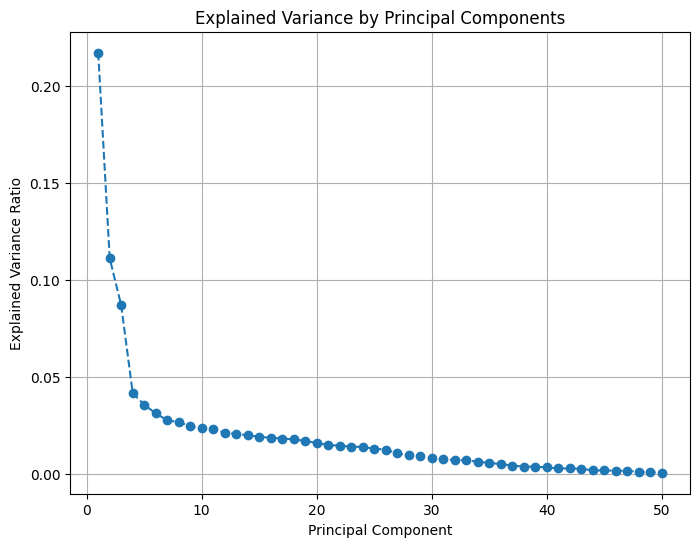

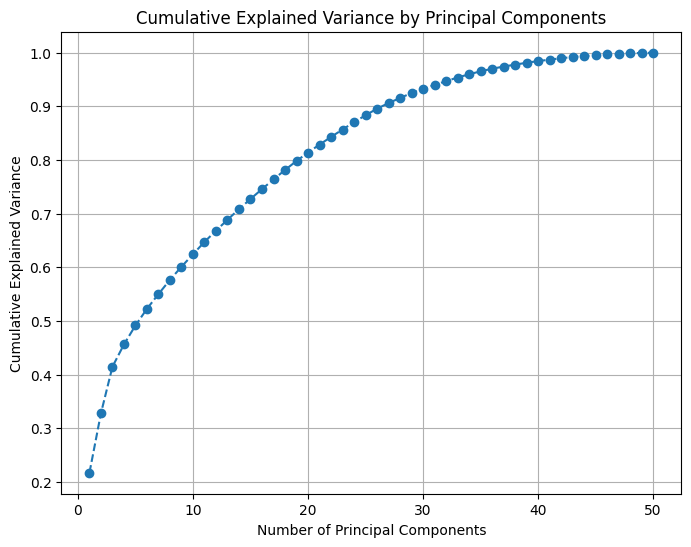

Number of components explaining at least 80% of the variance: 20
Number of components explaining at least 85% of the variance: 23
Number of components explaining at least 90% of the variance: 27
Number of components explaining at least 95% of the variance: 33
Number of components explaining at least 99% of the variance: 43


In [9]:
# Standardize the data before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)  # Assuming X_resampled is the feature data

# Apply PCA without specifying n_components to capture all components
pca = PCA()
pca.fit(X_scaled)

# Get the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance to visualize how much variance each component explains
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Calculate the cumulative explained variance
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance to identify the number of components needed
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Find the number of components that explain at least 90% of the variance
n_components_80 = next(i for i, total_var in enumerate(cumulative_explained_variance) if total_var >= 0.80) + 1
n_components_85 = next(i for i, total_var in enumerate(cumulative_explained_variance) if total_var >= 0.85) + 1
n_components_90 = next(i for i, total_var in enumerate(cumulative_explained_variance) if total_var >= 0.90) + 1
n_components_95 = next(i for i, total_var in enumerate(cumulative_explained_variance) if total_var >= 0.95) + 1
n_components_99 = next(i for i, total_var in enumerate(cumulative_explained_variance) if total_var >= 0.99) + 1

print(f'Number of components explaining at least 80% of the variance: {n_components_80}')
print(f'Number of components explaining at least 85% of the variance: {n_components_85}')
print(f'Number of components explaining at least 90% of the variance: {n_components_90}')
print(f'Number of components explaining at least 95% of the variance: {n_components_95}')
print(f'Number of components explaining at least 99% of the variance: {n_components_99}')

# Model 1 - Logistic Regression with RFE

In [ ]:
%%time

# Define the pipeline without GridSearchCV
logreg_rfe_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('rfe', RFE(estimator=LogisticRegression(random_state=42, max_iter=500), n_features_to_select=20)),
    ('logreg', LogisticRegression(random_state=42, max_iter=500, C=1.0, penalty='l2', solver='saga'))
])

# Fit the pipeline directly on the resampled data
logreg_rfe_pipeline.fit(X_resampled, y_resampled)

# Make predictions on the validation set
y_val_pred = logreg_rfe_pipeline.predict(X=X_val)

# Evaluate the model using classification report and accuracy score
print('Classification report for model : Logreg with RFE\n',  classification_report(y_val, y_val_pred))

# Plot ROC curve
y_val_pred_prob = logreg_rfe_pipeline.predict_proba(X_val)
plot_roc_curve(y_val, y_val_pred_prob[:, 1], 'Logreg with RFE')

print (f'RFE Top 20 features:\n{list(X_resampled.columns[logreg_rfe_pipeline["rfe"].support_])}\n')

# Create Kaggle submission
y_unseen_pred = logreg_rfe_pipeline.predict(X=unseen)
create_submission(id=unseen['id'], prediction=y_unseen_pred, model_name='logreg_rfe_pipeline_no_grid_search')

**Model Overview**: Logistic Regression with Recursive Feature Elimination (RFE).
- **Hyperparameters**:
  - Top 20 features selected by RFE: 
    - `Slope_total_ic_mou`, `Slope_total_rech_amt`, `Slope_arpu`, `Slope_roam_ic_mou`, `Slope_last_day_rech_amt`, `Slope_total_rech_num`, `Slope_loc_og_t2m_mou`, `aon`, `total_amt_6`, `total_amt_7`, `night_pck_user_8_-1.0`, `avg_rech_amt_6_7`, `avg_vbc_3g`, `Slope_vol_2g_mb`, `Slope_max_rech_data`, `rech_data_amt_7`, `Slope_vol_3g_mb`, `rech_data_amt_6`, `Slope_arpu_2g`, `Slope_total_rech_data`
- **Performance Summary**:
  - **Class 0 (Non-churn)**: High precision (0.98) and recall (0.89), resulting in a strong F1-score of 0.93.
  - **Class 1 (Churn)**: Precision is lower (0.37), while recall is relatively high (0.76). This indicates that the model captures many of the churn cases but produces a significant number of false positives.
  - **Overall Metrics**: 
    - Accuracy: 88%
    - The macro average F1-score is 0.71, suggesting imbalanced performance across classes, particularly in identifying true positives for churn.
- **ROC Curve**: AUC of 0.88 shows that the model has reasonable discriminatory power between the churn and non-churn classes.
- **Observation**:
  - The lower precision for the churn class (1) points to a notable number of false positives. Balancing this with improved precision could enhance customer retention insights, possibly through further tuning or incorporating additional features.

# Model 2 - Logistic Regression with PCA, RFE and Hyperparameter Tuning 

In [ ]:
%%time
# Create a pipeline with StandardScaler, PCA, RFE, and LogisticRegression
logreg_pca_rfe_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=n_components_90)),
    ('rfe', RFE(estimator=LogisticRegression(random_state=42), n_features_to_select=20)),
    ('logreg', LogisticRegression(random_state=42))
])

# Define a parameter grid for Logistic Regression
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10],       # Regularization strength
    'pca__n_components': [12, 15, 20],            # Number of PCA components to try
    'rfe__n_features_to_select': [10, 15, 20]     # RFE feature selection tuning
}

# Create the GridSearchCV object
grid_search_logreg = GridSearchCV(logreg_pca_rfe_pipeline, param_grid, cv=5, scoring='precision', n_jobs=-1)

# Fit the model using GridSearchCV
grid_search_logreg.fit(X_resampled, y_resampled)

# Evaluate the best model on the validation set
y_val_pred = grid_search_logreg.predict(X_val)

# Evaluate the model using classification report and accuracy score
print('Classification report for model : Logreg with PCA and RFE\n',  classification_report(y_val, y_val_pred))

# Plot ROC curve for the best model
y_val_pred_prob = grid_search_logreg.best_estimator_.predict_proba(X_val)
plot_roc_curve(y_val, y_val_pred_prob[:, 1], 'Logreg with PCA and RFE')

# Print best config
print (f'Best params :\n {grid_search_logreg.best_params_}\n')

# Make predictions on the unseen data
y_unseen_pred = grid_search_logreg.best_estimator_.predict(unseen)
create_submission(id=unseen['id'], prediction=y_unseen_pred, model_name='logreg_pca_rfe_tuned')

**Model Overview**: Logistic Regression with PCA and Recursive Feature Elimination (RFE).
- **Hyperparameters**:
  - `logreg_C`: 0.001
  - `pca_n_components`: 20
  - `rfe_n_features_to_select`: 10
- **Performance Summary**:
  - **Class 0 (Non-churn)**: High precision (0.97) and recall (0.85), leading to an F1-score of 0.91.
  - **Class 1 (Churn)**: Precision is low (0.30) with moderate recall (0.73), indicating a considerable number of false positives, resulting in a lower F1-score of 0.42.
  - **Overall Metrics**: 
    - Accuracy: 84%
    - Macro average F1-score is 0.67, pointing towards imbalanced model performance with a focus on better recall but lacking precision for the churn class.
- **ROC Curve**: AUC of 0.87 shows reasonable discriminatory ability between the churn and non-churn classes, though there is room for improvement.
- **Observation**:
  - The low precision for churn (class 1) suggests a high number of false positives, which could negatively impact retention strategies. Optimizing hyperparameters or incorporating additional features could help balance precision and recall for the churn class.

# Model 3 - Decision Tree with PCA and GridSearchCV

In [ ]:
%%time
# Define the pipeline with StandardScaler, PCA, and DecisionTreeClassifier
dt_pca_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=n_components_90)),
    ('dt', DecisionTreeClassifier(random_state=42))  # Decision Tree classifier
])

# Simplified parameter grid based on research insights
param_grid = {
    'pca__n_components': [12, 15, 20],        # Number of PCA components to try
    # 'dt__max_depth': [10, 15],              # Shallower trees help reduce overfitting; limit to 10 or 15
    'dt__min_samples_leaf': [10, 20],         # Larger minimum samples help generalize better in telecom churn data
    'dt__criterion': ['gini', 'entropy']                 # Stick with 'gini', commonly used and optimal for churn prediction
}

# Initialize GridSearchCV with DecisionTree and the reduced parameter grid
grid_search_dt = GridSearchCV(estimator=dt_pca_pipeline, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1)

# Fit the grid search on the resampled data
grid_search_dt.fit(X_resampled, y_resampled)

# Make predictions on the validation set
y_val_pred = grid_search_dt.predict(X_val)

# Evaluate the model using classification report and accuracy score
print('Classification report for model : DecisionTree with PCA\n',  classification_report(y_val, y_val_pred))

# Plot ROC curve
y_val_pred_prob = grid_search_dt.predict_proba(X_val)
plot_roc_curve(y_val, y_val_pred_prob[:, 1], 'DecisionTree with PCA')

# Print best config
print (f'Best params :\n {grid_search_dt.best_params_}\n')

# Create Kaggle submission with predictions for unseen data
y_unseen_pred = grid_search_dt.predict(X=unseen)
create_submission(id=unseen['id'], prediction=y_unseen_pred, model_name='dt_pca_pipeline')

**Model Overview**: Decision Tree with PCA.
- **Hyperparameters**:
  - `dt__criterion`: 'entropy'
  - `dt__min_samples_leaf`: 10
  - `pca__n_components`: 12
- **Performance Summary**:
  - **Class 0 (Non-churn)**: Very high precision (0.99) and recall (0.93), leading to a strong F1-score of 0.96.
  - **Class 1 (Churn)**: Moderate precision (0.50) with high recall (0.86), indicating that the model captures many churn cases but also has a significant number of false positives. This results in an F1-score of 0.63.
  - **Overall Metrics**:
    - Accuracy: 92%
    - Macro average F1-score is 0.79, indicating a relatively balanced performance, though precision for churn could still be improved.
- **ROC Curve**: AUC of 0.98 demonstrates excellent discriminatory ability between churn and non-churn classes.
- **Observation**:
  - The model achieves high recall for the churn class, which is beneficial for capturing most of the churn cases. However, the moderate precision for churn suggests there are false positives that could be addressed by further tuning hyperparameters or refining feature selection.

# Model 4 - Random Forest with PCA and GridSearchCV

Classification report for model : RandomForest with PCA
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      3871
           1       0.71      0.95      0.82       329

    accuracy                           0.97      4200
   macro avg       0.85      0.96      0.90      4200
weighted avg       0.97      0.97      0.97      4200



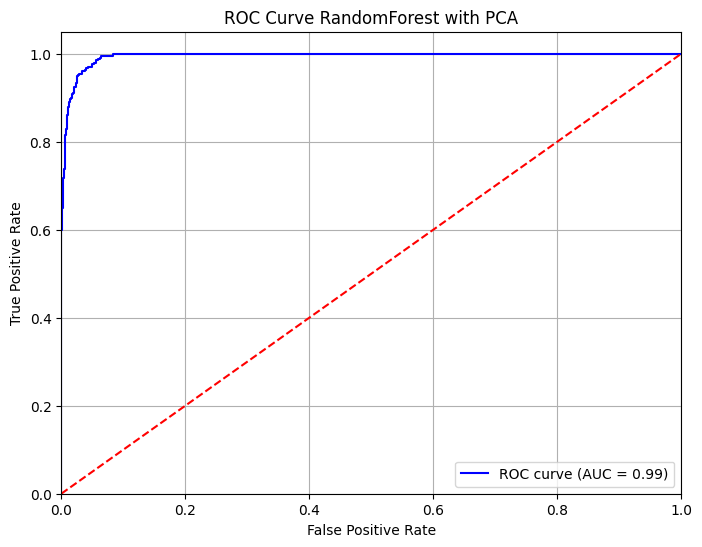

Best params :
 {'pca__n_components': 20, 'rf__max_depth': 20, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}



NameError: name 'unseen' is not defined

In [10]:
%%time
# Define the pipeline with StandardScaler, PCA, and RandomForestClassifier
rf_pca_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=n_components_90)),  
    ('rf', RandomForestClassifier(random_state=42)) 
])

# Simplified parameter grid based on research insights
param_grid = {
    'pca__n_components': [15, 20],            # Number of PCA components to try
    'rf__n_estimators': [100, 200],           # Limit number of trees to 100 or 200 (typically for telecom data)
    'rf__max_depth': [7, 10, 20],             # Shallower trees (10-20) to avoid overfitting
    'rf__min_samples_split': [5, 10],         # Common settings, reduces overfitting without too much complexity
    'rf__min_samples_leaf': [5, 7]            # Minimum leaf size - keep smaller for better churn prediction
}

# Initialize GridSearchCV with RandomForestClassifier and the reduced parameter grid
grid_search_rf = GridSearchCV(estimator=rf_pca_pipeline, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1)

# Fit the grid search on the resampled data
grid_search_rf.fit(X_resampled, y_resampled)

# Make predictions on the validation set
y_val_pred = grid_search_rf.predict(X_val)

# Evaluate the model using classification report and accuracy score
print('Classification report for model : RandomForest with PCA\n',  classification_report(y_val, y_val_pred))

# Plot ROC curve
y_val_pred_prob = grid_search_rf.predict_proba(X_val)
plot_roc_curve(y_val, y_val_pred_prob[:, 1], 'RandomForest with PCA')

# Print best config
print (f'Best params :\n {grid_search_rf.best_params_}\n')

# Create Kaggle submission with predictions for unseen data
y_unseen_pred = grid_search_rf.predict(X=unseen)
create_submission(id=unseen['id'], prediction=y_unseen_pred, model_name='rf_pca_pipeline')

**Model Overview**: Random Forest with PCA.
- **Hyperparameters**:
  - `pca__n_components`: 20
  - `rf__max_depth`: 20
  - `rf__min_samples_leaf`: 5
  - `rf__min_samples_split`: 5
  - `rf__n_estimators`: 200
- **Performance Summary**:
  - **Class 0 (Non-churn)**: Perfect precision (1.00) and high recall (0.97), resulting in an F1-score of 0.98.
  - **Class 1 (Churn)**: High precision (0.71) and excellent recall (0.95), leading to an F1-score of 0.82.
  - **Overall Metrics**:
    - Accuracy: 97%
    - Macro average F1-score is 0.90, indicating strong performance across both classes with a good balance of precision and recall.
- **ROC Curve**: AUC of 0.99 indicates that the model is very effective at distinguishing between churn and non-churn classes.
- **Observation**:
  - The high recall for churn class (1) means the model is capturing most churn cases effectively, while also maintaining good precision, which minimizes false positives. This balanced performance is promising, but further tuning may further optimize precision to reach near-perfect results.

# Model 5 - XGBoost with PCA and GridSearchCV

In [ ]:
%%time
# Define the pipeline with StandardScaler, PCA, and XGBClassifier
xgb_pca_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA()),  # PCA without fixed n_components so we can control it through param_grid
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))  # XGBoost classifier
])

# Simplified parameter grid with different PCA components
param_grid = {
    'pca__n_components': [13, 16,20, 25],       # Number of PCA components to try
    'xgb__n_estimators': [100, 200],            # Limit the number of boosting rounds (200 should be sufficient for our data)
    'xgb__max_depth': [3, 5],                   # Tree depth around 3-5 tends to generalize well
    'xgb__learning_rate': [0.1],                # 0.1 is a balanced learning rate commonly used in telecom churn models
    'xgb__subsample': [0.8],                    # Use a constant subsample ratio of 0.8 for less overfitting
    'xgb__colsample_bytree': [0.8],             # Column sampling ratio of 0.8 works well for moderately high-dimensional data
    'xgb__min_child_weight': [1]                # Child weight of 1 often provides the right balance for handling noise in telecom data
}

# Initialize GridSearchCV with XGBClassifier and the modified parameter grid
grid_search_xgb = GridSearchCV(estimator=xgb_pca_pipeline, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1)

# Fit the grid search on the resampled data
grid_search_xgb.fit(X_resampled, y_resampled)

# Make predictions on the validation set
y_val_pred = grid_search_xgb.predict(X_val)

# Evaluate the model using classification report and accuracy score
print('Classification report for model : XGBoost with PCA\n',  classification_report(y_val, y_val_pred))

# Plot ROC curve
y_val_pred_prob = grid_search_xgb.predict_proba(X_val)
plot_roc_curve(y_val, y_val_pred_prob[:, 1], 'XGBoost with PCA')

# Print best config
print (f'Best params :\n {grid_search_xgb.best_params_}\n')

# Create Kaggle submission with predictions for unseen data
y_unseen_pred = grid_search_xgb.predict(X=unseen)
create_submission(id=unseen['id'], prediction=y_unseen_pred, model_name='XGBoost with PCA')

**Model Overview**: XGBoost with PCA.
- **Hyperparameters**:
  - `pca__n_components`: 25
  - `xgb__colsample_bytree`: 0.8
  - `xgb__learning_rate`: 0.1
  - `xgb__max_depth`: 5
  - `xgb__min_child_weight`: 1
  - `xgb__n_estimators`: 200
  - `xgb__subsample`: 0.8
- **Performance Summary**:
  - **Class 0 (Non-churn)**: Very high precision (0.99) and recall (0.94), leading to an excellent F1-score of 0.97.
  - **Class 1 (Churn)**: Moderate precision (0.57) with high recall (0.86), indicating that the model effectively captures most churn cases, though false positives are still present. This results in an F1-score of 0.68.
  - **Overall Metrics**:
    - Accuracy: 94%
    - Macro average F1-score is 0.82, showing that the model performs well overall, though there is still room to improve precision for the churn class.
- **ROC Curve**: AUC of 0.97 indicates strong discriminatory power between churn and non-churn classes.
- **Observation**:
  - The model achieves high recall for the churn class, beneficial for detecting churn cases, but the lower precision suggests false positives need addressing. Additional tuning or feature engineering could help to further improve precision for better balance.

# Final Model Summary 

- **Best Model**: RandomForest with PCA

- **Key Reasons**:
  - **Balanced Performance**: The RandomForest model with PCA achieved a high accuracy of 97%, with both precision and recall values being consistently strong for both churn and non-churn classes.
  - **High Recall for Churn Class**: The model performs particularly well in identifying churn cases (class '1'), with a recall of 0.95, ensuring that most customers likely to churn are correctly identified. This aligns well with the focus on maximizing recall to minimize false negatives.
  - **High AUC**: The ROC AUC score of 0.99 indicates excellent capability in distinguishing between churn and non-churn customers, providing confidence in its discriminative power.
  - **Low False Positives**: Compared to other models like Decision Tree and XGBoost, RandomForest demonstrates better precision for the churn class, resulting in fewer false positives. This is crucial for reducing unnecessary retention efforts and costs.
  - **Stability**: RandomForest's performance is less impacted by class imbalance compared to models like Logistic Regression, making it a more reliable and stable choice for this churn prediction task.

# Recommendations

1. Changes in usage or spending are the best indicators of potential churn.
2. To build a more reliable trend or slope, it is recommended to track key performance indicators (KPIs) for at least four months (longer is better), using the first month as a baseline and the next three months to establish a trend leading up to the fourth month.
3. The current slope features are sensitive to edge cases. Better data explanation will help in developing a more robust change/slope metric.
4. Metrics like high-value customers should be defined by the business rather than assumed.
5. The current modeling approach is based on derived change metrics (slopes) for all monthly KPIs. This approach should be refined by including only a few key variables as slope features.
6. The Random Forest model is currently the best-performing model, but it is also the most computationally expensive. XGBoost and Decision Tree models have the potential to perform similarly with further tuning.
7. The following indicatores are key drivers based on the current modeling and should be monitored to predict churn:
    - average revenue per user (ARPU)
    - average revenue per user for 2G services
    - last day recharge amount
    - local outgoing minutes to mobile
    - maximum recharge data amount
    - roaming incoming minutes of usage
    - total incoming minutes of usage
    - total recharge amount
    - total recharge data amount
    - total number of recharges
    - 2G data volume in MB
    - 3G data volume in MB
    - age on network (AON)
    - average recharge amount for months June and July v/s recharge in August
    - average volume-based cost for 3G
    - night packs
    - recharge data amount
    - total recharge amount

# Kaggle competition model


`RandomForest with PCA` performs well on Kaggle with score at `0.89650` but based on EDA we can build a simpler model for competition with score `0.92190`

In [ ]:
# Load data
kdata = pd.read_csv("data/train.csv")
kunseen = pd.read_csv("data/test.csv")

# Helper functions for calculating changes
def calculate_arpu_change(row):
    if pd.notna(row['arpu_8']) and pd.notna(row['arpu_7']):
        return (row['arpu_8'] - row['arpu_7']) / (abs(row['arpu_7']) + 1e-5)
    elif pd.notna(row['arpu_7']) and pd.notna(row['arpu_6']):
        return (row['arpu_7'] - row['arpu_6']) / (abs(row['arpu_6']) + 1e-5)
    elif pd.notna(row['arpu_8']) and pd.notna(row['arpu_6']):
        return (row['arpu_8'] - row['arpu_6']) / (abs(row['arpu_6']) + 1e-5)
    return 0

def calculate_recharge_change(row):
    if pd.notna(row['total_rech_amt_8']) and pd.notna(row['total_rech_amt_7']):
        return (row['total_rech_amt_8'] - row['total_rech_amt_7']) / (abs(row['total_rech_amt_7']) + 1e-5)
    elif pd.notna(row['total_rech_amt_7']) and pd.notna(row['total_rech_amt_6']):
        return (row['total_rech_amt_7'] - row['total_rech_amt_6']) / (abs(row['total_rech_amt_6']) + 1e-5)
    elif pd.notna(row['total_rech_amt_8']) and pd.notna(row['total_rech_amt_6']):
        return (row['total_rech_amt_8'] - row['total_rech_amt_6']) / (abs(row['total_rech_amt_6']) + 1e-5)
    return 0

# Calculate and add new features
for df in [kdata, kunseen]:
    df.loc[:, 'latest_arpu_change'] = df.apply(calculate_arpu_change, axis=1)
    df.loc[:, 'latest_rech_amt_change'] = df.apply(calculate_recharge_change, axis=1)

# Filter necessary columns
kdata = kdata[['latest_arpu_change', 'latest_rech_amt_change', 'aon', 'churn_probability']].copy(deep=True)
kunseen = kunseen[['id', 'latest_arpu_change', 'latest_rech_amt_change', 'aon']].copy(deep=True)

# Prepare train-test split
X_train, X_val, y_train, y_val = train_test_split(
    kdata.drop(columns=['churn_probability']), kdata['churn_probability'], 
    test_size=0.3, random_state=42
)

# Train the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = xgb_model.predict(X_val)

# Evaluate the model using classification report and accuracy score
print('Classification report for model : XGBoost with three features\n',  classification_report(y_val, y_val_pred))

# Plot ROC curve
y_val_pred_prob = xgb_model.predict_proba(X_val)
plot_roc_curve(y_val, y_val_pred_prob[:, 1], 'Kaggle - XGBoost with three features')

# Predict on unseen data and create submission
kunseen.loc[:, 'churn_probability'] = xgb_model.predict(kunseen.drop(columns='id'))
create_submission(id=kunseen['id'], prediction=kunseen['churn_probability'], model_name='')

### Kaggle submission Model Performance Summary:

`Kaggle score `: **0.92190**

The model performs well in predicting **non-churn (Class 0)** cases, with high precision, recall, and F1-score. However, **churn (Class 1)** is more challenging for the model, as indicated by lower recall (0.40), which suggests that many actual churners are not being identified. This is likely because the dataset is imbalanced, and the model has a bias toward the majority class (non-churn).

**Macro and Weighted Averages**:
- The macro average (averaging the metrics across both classes) for recall is **0.69**, and the F1-score is **0.73**, indicating that the model struggles with the minority class.
- The weighted average is better due to the larger support for non-churn cases.

**ROC Curve and AUC**:
- The ROC curve shows a good separation between classes, with an **AUC (Area Under Curve) of 0.84**, indicating a reasonably strong model in distinguishing between churners and non-churners.
- The ROC curve demonstrates good predictive power but suggests room for improvement, especially in minimizing false negatives for churn cases.

**Summary**:
The model shows **high accuracy** and performs well for the **majority class (non-churn)** but struggles with **minority class (churn)** due to class imbalance. The **AUC of 0.84** suggests a solid model, but the relatively low recall for churn cases (0.40) implies that further improvements, such as balancing techniques or hyperparameter tuning, are needed to enhance recall and overall performance for churn prediction.